In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from preprocessing import load_if_in_country_or_lang
from preprocessing import categorize_views_for_df
from processing import filter_by_region_cat_code, build_regression_dataframe, load_preprocessed_events
from plot_regression import plot_regression_results_from_dict
import numpy as np
from regression import fit_nb_with_estimated_alpha, estimate_alpha, fit_nb, standardize_var, fit_nb_with_estimated_alpha_all_codes, standardize_var

In [72]:
df_crawled = pd.read_csv('events/new/processed_0_manually_with_wikiviews.csv').drop_duplicates()

In [73]:
df_crawled[df_crawled.cat == 'undefined'].head()

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,in_code_lang,in_code_region,date_month,views_baseline,view_country_article
200,Q107353229,Chinese elephants expedition,2020-03-01,Global South,China,Asia,undefined,"['Category:2021 in China', 'Category:Animal mi...",0,0.000000,...,China,2020.0,10228.970558,1.472280e+13,False,False,False,2020-03-01,1.842000e+06,20676.5
214,Q109110309,Wikipedia:Meetup/Johor 9,2019-05-01,Global South,Malaysia,Asia,undefined,"['Category:Wikipedia meetups in Malaysia', 'Ca...",0,0.000000,...,Malaysia,2019.0,11414.290367,3.646840e+11,False,False,False,2019-05-01,5.815000e+07,9350.0
245,Q138837,Catalan Republic (2017),2017-10-27,Global North,Spain,Europe,undefined,['Category:Redirects connected to a Wikidata i...,392630,0.000000,...,Spain,2017.0,28137.441564,1.312539e+12,True,False,False,2017-10-01,4.312950e+07,11320.0
247,Q1437630,"Solar eclipse of August 21, 2017",2017-08-21,Global North,United States,North America,undefined,"['Category:2017 in science', 'Category:2017 in...",1244878,157979.285714,...,United States,2017.0,59921.674703,1.947962e+13,True,True,True,2017-08-01,3.217767e+09,44815.0
1014,Q22081742,Wikipedia:Meetup/justfortherecord/Events/heroines,2016-01-15,Global North,Belgium,Europe,undefined,[],0,0.000000,...,Belgium,2016.0,41899.065629,4.757396e+11,True,False,False,2016-01-01,2.536950e+07,8722.0


In [77]:
df_crawled = df_crawled[df_crawled.cat != 'undefined']
df_crawled = df_crawled.drop_duplicates()
df_crawled[df_crawled.pagetitle.duplicated(keep=False)]

,event_id,pagetitle,event_date,economic_region,country,continent,cat,categories,views_7_sum,views_before_mean,...,Country/Area,Year,GDP_pc,GDP,oecd,in_code_lang,in_code_region,date_month,views_baseline,view_country_article


In [409]:
df_crawled.columns.startswith('views')

Index(['event_id', 'pagetitle', 'event_date', 'economic_region', 'country',
       'continent', 'cat', 'categories', 'views_7_sum', 'views_before_mean',
       'views_before_sum', 'views_before_max', 'views_before_min',
       'views_before_median', 'views_before_increase', 'list_views_7_days',
       'diff_days', 'year', 'planed', 'surprising', 'factor', 'page_creation',
       'edits_7_sum', 'edits_before_min', 'edits_before_mean',
       'edits_before_max', 'edits_before_median', 'edits_before_sum', 'code',
       'bing_hits', 'gni_class', 'gni_region', 'population', 'Country/Area',
       'Year', 'GDP_pc', 'GDP', 'oecd', 'in_code_lang', 'in_code_region',
       'date_month', 'views_baseline', 'view_country_article', 'noticed'],
      dtype='object')

In [415]:
df_crawled[df_crawled.views_before_sum > df_crawled.views_7_sum][['code', 'pagetitle','event_date', 'views_before_sum', 'views_7_sum']]

,code,pagetitle,event_date,views_before_sum,views_7_sum
11,en,2020 International Darts Open,2020-10-01,772,313
97,en,2021 New Year Honours (New Zealand),2020-12-31,2043,1875
162,en,2020 Phoenix mayoral election,2020-11-03,3129,2423
243,en,"Nigerien presidential election, 2004",2015-11-16,41,31
277,en,2016 Democratic National Convention,2016-07-25,209073,207141
...,...,...,...,...,...
19544,es,Tianguis Turístico,2019-04-10,1862,741
19559,es,Gran Premio del 70.º Aniversario,2020-08-09,4963,4547
19584,es,Gran Premio de España de Motociclismo de 2020,2020-07-19,1503,1322
19609,es,Gran Premio de Cataluña de Motociclismo de 2020,2020-09-27,751,712


# Analyze views-after vs. views/before

TODO: build a regression which measures if an event gathers more than n views on Wikipedia

In [119]:
for code, df in df_crawled.groupby('code'):
    n_events_total = len(df)
    print(f'Analysing {code} ({n_events_total} Events)')

    for v in [0, 10, 100, 1000]: # [0.05, 1, 5, 10]:
        events_rel = df[(df.views_7_sum <= v)]
        #min_v = v * df.views_baseline / 1000000
        #events_rel = df[df.views_7_sum < min_v]
        n_events_rel = len(events_rel)
        print(f'\tLess than {v+1} views: {n_events_rel} ({n_events_rel/n_events_total*100:.2f}%)')

Analysing de (3375 Events)
	Less than 1 views: 1653 (48.98%)
	Less than 11 views: 1662 (49.24%)
	Less than 101 views: 1811 (53.66%)
	Less than 1001 views: 2568 (76.09%)
Analysing en (8184 Events)
	Less than 1 views: 1283 (15.68%)
	Less than 11 views: 1302 (15.91%)
	Less than 101 views: 1477 (18.05%)
	Less than 1001 views: 3067 (37.48%)
Analysing es (3628 Events)
	Less than 1 views: 770 (21.22%)
	Less than 11 views: 781 (21.53%)
	Less than 101 views: 1124 (30.98%)
	Less than 1001 views: 2256 (62.18%)
Analysing it (2793 Events)
	Less than 1 views: 1155 (41.35%)
	Less than 11 views: 1194 (42.75%)
	Less than 101 views: 1531 (54.82%)
	Less than 1001 views: 2176 (77.91%)


In [88]:
for code, df in df_crawled.groupby('code'):
    n_events_total = len(df)
    print(f'Analysing {code} ({n_events_total} Events)')

    for v in [0.01, 0.05, 0.1, 0.25, 0.5]:
        n_min_events = int(np.ceil(n_events_total*v))
        events_rel = df.nsmallest(n_min_events, 'views_7_sum')
        #min_v = v * df.views_baseline / 1000000
        #events_rel = df[df.views_7_sum < min_v]
        n_events_rel = len(events_rel)
        print(f'\tSmallest {n_min_events} events (bottom {v*100}%): {n_events_rel} ({n_events_rel/n_events_total*100:.2f}%)')
        print(f'\t\tViews by "largest of the smallest": {events_rel.tail(1).views_7_sum.values[0]}')

Analysing de (3375 Events)
	Smallest 34 events (bottom 1.0%): 34 (1.01%)
		Views by "largest of the smallest": 0
	Smallest 169 events (bottom 5.0%): 169 (5.01%)
		Views by "largest of the smallest": 0
	Smallest 338 events (bottom 10.0%): 338 (10.01%)
		Views by "largest of the smallest": 0
	Smallest 844 events (bottom 25.0%): 844 (25.01%)
		Views by "largest of the smallest": 0
	Smallest 1688 events (bottom 50.0%): 1688 (50.01%)
		Views by "largest of the smallest": 31
Analysing en (8184 Events)
	Smallest 82 events (bottom 1.0%): 82 (1.00%)
		Views by "largest of the smallest": 0
	Smallest 410 events (bottom 5.0%): 410 (5.01%)
		Views by "largest of the smallest": 0
	Smallest 819 events (bottom 10.0%): 819 (10.01%)
		Views by "largest of the smallest": 0
	Smallest 2046 events (bottom 25.0%): 2046 (25.00%)
		Views by "largest of the smallest": 334
	Smallest 4092 events (bottom 50.0%): 4092 (50.00%)
		Views by "largest of the smallest": 2853
Analysing es (3628 Events)
	Smallest 37 events

In [96]:
df_crawled['noticed'] = df_crawled.views_7_sum > 10

### Investigation of "noticed" events

In [99]:
from plot_regression import plot_cat_by_cat, plot_cat_by_cat_variable

In [124]:
f'{sum(df_crawled.noticed) / len(df_crawled)*100:.2f}% of OVERALL articles have >10 views'

'72.53% of OVERALL articles have >10 views'

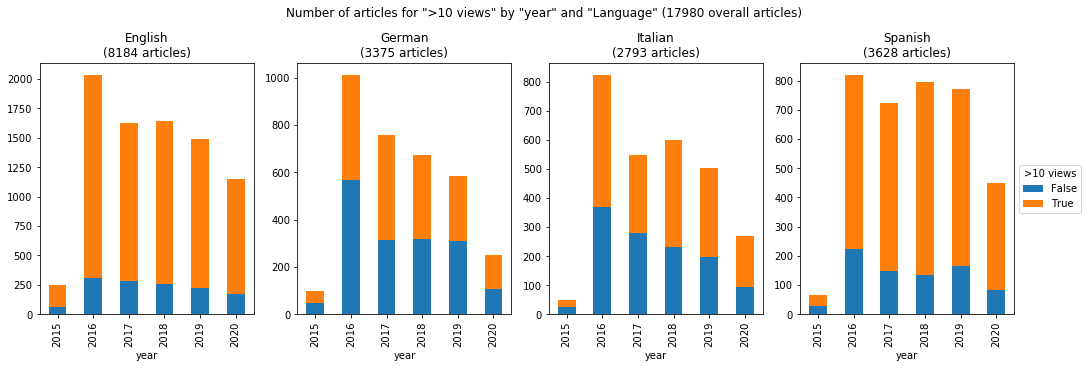

In [128]:
plot_cat_by_cat_variable(df_crawled, col_plot='code', col_x = 'year', col_bar='noticed', stacked=True, sharey=False, figsize=(15, 5))

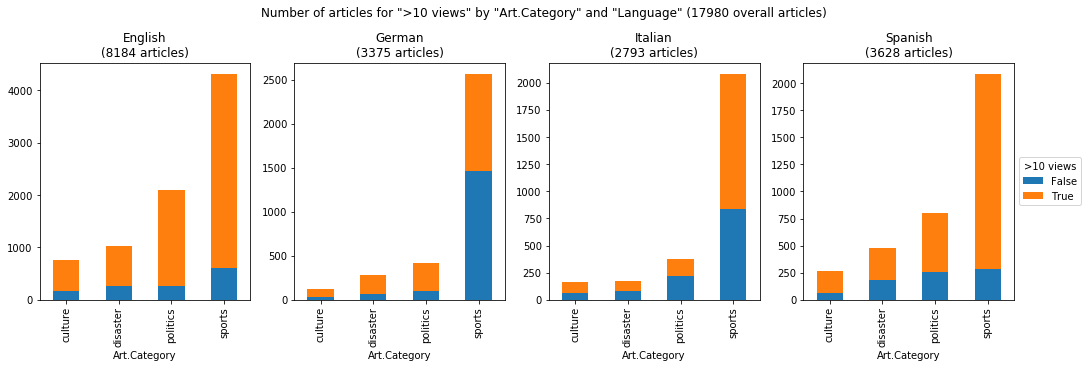

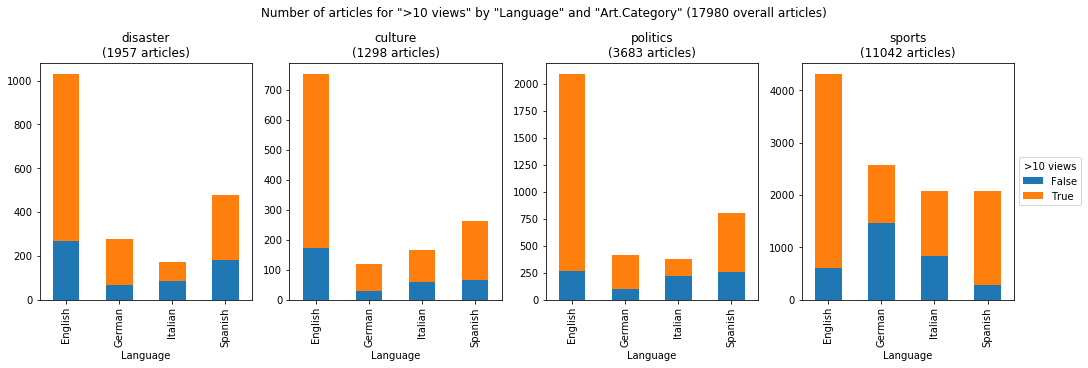

In [127]:
plot_cat_by_cat_variable(df_crawled, col_plot='code', col_x = 'cat', col_bar='noticed', stacked=True, sharey=False, figsize=(15, 5))
plot_cat_by_cat_variable(df_crawled, col_plot='cat', col_x = 'code', col_bar='noticed', stacked=True, sharey=False, figsize=(15, 5))

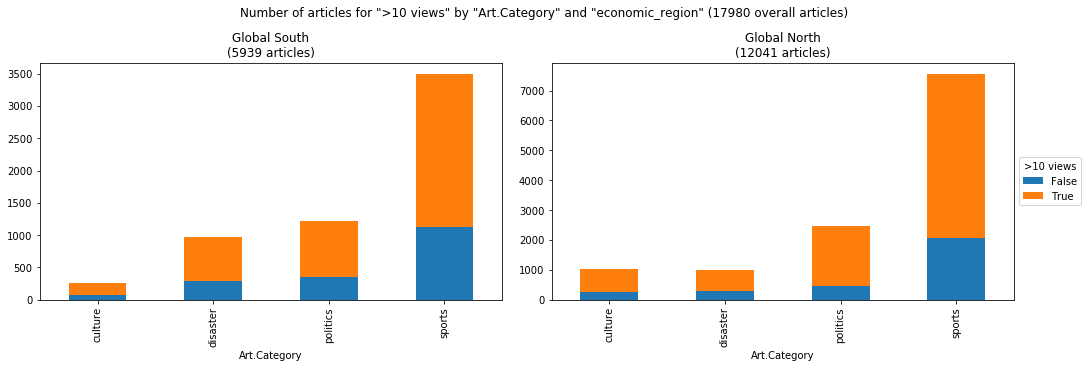

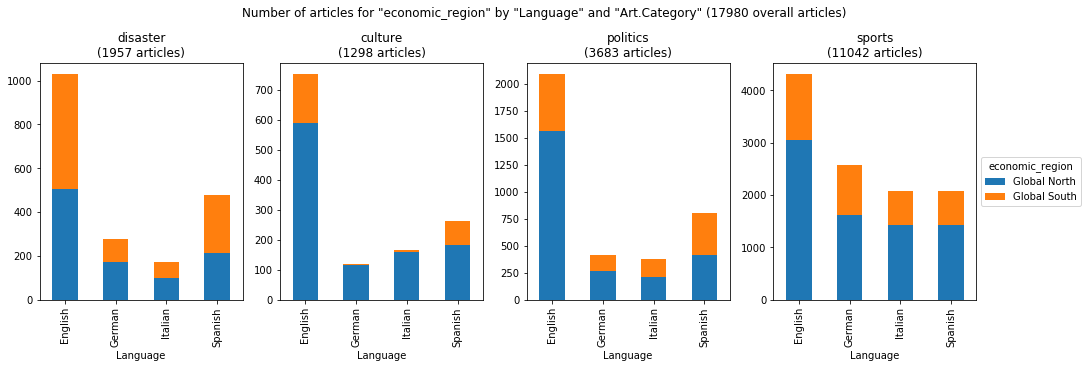

In [380]:
plot_cat_by_cat_variable(df_crawled, col_plot='economic_region', col_x = 'cat', col_bar='noticed', stacked=True, sharey=False, figsize=(15, 5))
plot_cat_by_cat_variable(df_crawled, col_plot='cat', col_x = 'code', col_bar='economic_region', stacked=True, sharey=False, figsize=(15, 5))

# Regression

In [297]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from plot_regression import BASELINE_DICT, CAT_DICT, LABEL_RENAME_DICT, LABEL_SORT_DICT
from regression import transform_vars_for_regression, fit_logit_and_rename_coeffs, fit_regression_and_rename_coeffs_by_cat, nagelkerke, mcfadden, likelihood_ratio_test

df_reg = df_crawled[df_crawled.year > 2015]
df_reg = transform_vars_for_regression(df_reg.copy())
df_reg['noticed_int'] = df_reg.noticed.astype(int)
df_reg.describe()

,views_7_sum,views_before_mean,views_before_sum,views_before_max,views_before_min,views_before_median,views_before_increase,diff_days,year,edits_7_sum,...,views_baseline_z,view_country_article_z,bing_hits_z,view_country_article_log,views_baseline_log,bing_hits_log,GDP_pc_log,GDP_log,population_log,noticed_int
count,1.752400e+04,17524.000000,1.752400e+04,17524.000000,17524.000000,17524.000000,17524.000000,17524.000000,17524.000000,17524.000000,...,1.752400e+04,1.752400e+04,1.752400e+04,17524.000000,17524.000000,17524.000000,17524.000000,17524.000000,17524.000000,17524.000000
mean,1.879354e+04,505.729635,3.478577e+03,945.726432,297.645743,432.918569,487.016149,-19.412406,2017.689226,26.435974,...,2.919372e-17,-6.487494e-18,9.731240e-18,8.685505,16.197235,6.212895,9.939394,27.755795,17.815382,0.727517
std,1.221306e+05,3626.362287,2.535814e+04,6945.623872,2399.728356,3069.400341,4268.468788,507.707605,1.362913,100.797535,...,1.000000e+00,1.000000e+00,1.000000e+00,1.292987,3.472149,4.145783,1.151321,2.076593,1.717646,0.445250
min,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-35168.000000,-5990.000000,2016.000000,0.000000,...,-4.186023e-01,-8.470508e-01,-2.406814e-01,0.000000,0.000000,0.000000,4.676027,17.665728,9.256747,0.000000
25%,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-79.000000,2016.000000,0.000000,...,-4.178164e-01,-6.722900e-01,-2.406252e-01,7.802822,13.570889,2.756454,9.076299,26.605787,16.731682,0.000000
50%,6.005000e+02,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,-3.000000,2018.000000,2.000000,...,-4.039807e-01,-3.838794e-01,-2.403270e-01,8.777247,16.494303,4.543295,10.409898,28.131505,18.006057,1.000000
75%,5.581500e+03,105.571429,5.840000e+02,195.000000,48.000000,83.000000,79.000000,6.000000,2019.000000,17.000000,...,-3.051591e-01,1.025077e-01,-1.557060e-01,9.495068,18.543106,10.012387,10.818299,28.696005,19.144178,1.000000
max,7.847440e+06,188749.000000,1.321243e+06,443489.000000,134559.000000,150619.000000,316295.000000,2143.000000,2020.000000,3887.000000,...,3.050404e+00,3.154267e+00,2.997703e+01,10.933393,21.963427,15.886164,12.152185,30.693130,21.067514,1.000000


#### Possible Features:
- Article features
    - category (categorical)
    - views 7d before the event
    - views 7d after the event
    - edits
- Wikipedia features
    - Event country has the article's Wikipeida version's language as an "official language" (bool)
    - Median daily pagviews from the event country to the language edition in the last 5 months
    - Median pageviews to the main article of the event country in the language edition in the last 5 months
    - Whether the Wikipedia language version spans multiple regions (bool)
- Geographical features
    - country (categorical)
    - continent (categorical)
    - geographic region via the world bank (categorical)
- Economical features
    - GDP
    - GDP per capita
    - oecd member (bool)
    - Country income class via the world bank (categorical)
- Media features:
    - Bing news hits when using article pagetitle as the search query in early 2022

In [408]:
logreg_0 = fit_logit_and_rename_coeffs(
    df_reg, 'noticed_int ~ C(code, Treatment(reference="en")) * (C(cat, Treatment(reference="sports")) + gni_class + gni_region + economic_region)', robust=False)
#logreg_0.summary2().to_frame()
logreg_2 = fit_logit_and_rename_coeffs(
    df_reg, 'noticed_int ~ C(code, Treatment(reference="en")) * (C(cat, Treatment(reference="sports")) + gni_class)', robust=False)
logreg_3 = fit_logit_and_rename_coeffs(
    df_reg, 'noticed_int ~ C(code, Treatment(reference="en")) * (C(cat, Treatment(reference="sports")) + gni_class) + views_baseline_z + view_country_article_z', robust=False)
logreg_3 = fit_logit_and_rename_coeffs(
    df_reg, 'noticed_int ~ C(code, Treatment(reference="en")) * (C(cat, Treatment(reference="sports")) + gni_region + GDP_pc_z ) + bing_hits_log + views_baseline_z + view_country_article_z', robust=False)

PseudoR² - Nagelkerke: 0.203 | Mcfadden: 0.129
PseudoR² - Nagelkerke: 0.190 | Mcfadden: 0.120
PseudoR² - Nagelkerke: 0.191 | Mcfadden: 0.121
PseudoR² - Nagelkerke: 0.274 | Mcfadden: 0.179


In [373]:
code_reg = 'C(code, Treatment(reference="en"))'
cat_reg = 'C(cat, Treatment(reference="sports"))'
class_reg = 'C(gni_class, Treatment(reference="H"))'
region_reg = 'C(gni_region, Treatment(reference="North America"))'
continent_reg = 'C(gni_region, Treatment(reference="North America"))'

logreg_1 = fit_logit_and_rename_coeffs(
    df_reg, 
    f'noticed_int ~ {code_reg} * {cat_reg} * {class_reg} + views_baseline_z + view_country_article_z')
logreg_1.summary2()

PseudoR² - Nagelkerke: 0.199 | Mcfadden: 0.126


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                  Results: Generalized linear model
=====================================================================================================
Model:                          GLM                          AIC:                        18072.5167  
Link Function:                  logit                        BIC:                        -152662.8466
Dependent Variable:             noticed_int                  Log-Likelihood:             -8972.3     
Date:                           2022-04-28 13:42             LL-Null:                    -10264.     
No. Observations:               17524                        Deviance:                   17945.      
Df Model:                       63                           Pearson chi2:               1.75e+04    
Df Residuals:                   17460                        Scale:                      1.0000      
Method:                         IRLS                                                                 
-----------------------------------------------------------------------------------------------------
                                            Coef.    Std.Err.     z     P>|z|     [0.025     0.975]  
-----------------------------------------------------------------------------------------------------
Intercept                                    1.7175     0.0583  29.4444 0.0000      1.6032     1.8318
code[T.de]                                  -1.6395     0.0855 -19.1687 0.0000     -1.8072    -1.4719
code[T.es]                                   0.0780     0.1005   0.7765 0.4375     -0.1189     0.2749
code[T.it]                                  -1.3076     0.0931 -14.0511 0.0000     -1.4900    -1.1252
cat[T.culture]                              -0.3162     0.1223  -2.5845 0.0098     -0.5560    -0.0764
cat[T.disaster]                             -0.7266     0.1221  -5.9526 0.0000     -0.9658    -0.4874
cat[T.politics]                              0.1226     0.0970   1.2647 0.2060     -0.0674     0.3127
gni_class[T.L]                              -0.8284     0.6938  -1.1941 0.2324     -2.1882     0.5314
gni_class[T.LM]                             -0.4716     0.1603  -2.9429 0.0033     -0.7857    -0.1575
gni_class[T.UM]                              0.5643     0.1207   4.6773 0.0000      0.3279     0.8008
code[T.de]:cat[T.culture]                    1.4414     0.2602   5.5401 0.0000      0.9314     1.9513
code[T.es]:cat[T.culture]                   -0.2776     0.2228  -1.2461 0.2127     -0.7143     0.1591
code[T.it]:cat[T.culture]                    0.6068     0.2181   2.7817 0.0054      0.1792     1.0343
code[T.de]:cat[T.disaster]                   1.6866     0.2329   7.2430 0.0000      1.2302     2.1430
code[T.es]:cat[T.disaster]                  -0.6012     0.2052  -2.9294 0.0034     -1.0034    -0.1989
code[T.it]:cat[T.disaster]                   0.3586     0.2709   1.3240 0.1855     -0.1723     0.8895
code[T.de]:cat[T.politics]                   1.3605     0.2022   6.7280 0.0000      0.9641     1.7568
code[T.es]:cat[T.politics]                  -1.0212     0.1621  -6.2992 0.0000     -1.3389    -0.7035
code[T.it]:cat[T.politics]                  -0.3739     0.1881  -1.9879 0.0468     -0.7426    -0.0053
code[T.de]:gni_class[T.L]                   -1.0701     1.0293  -1.0396 0.2985     -3.0876     0.9473
code[T.es]:gni_class[T.L]                   20.6504 16877.3575   0.0012 0.9990 -33058.3624 33099.6631
code[T.it]:gni_class[T.L]                    1.1644     1.4084   0.8267 0.4084     -1.5960     3.9247
code[T.de]:gni_class[T.LM]                  -0.5848     0.2384  -2.4535 0.0141     -1.0520    -0.1176
code[T.es]:gni_class[T.LM]                  -0.1778     0.3318  -0.5358 0.5921     -0.8282     0.4726
code[T.it]:gni_class[T.LM]                  -0.6070     0.3337  -1.8192 0.0689     -1.2610     0.0470
code[T.de]:gni_class[T.UM]                  -1.4391     0.1535  -9.3773 0.0000     -1.7399    -1.1383
code[T.

In [335]:
fit_logit_and_rename_coeffs(
    df_reg[df_reg.code=='en'], 
    f'noticed_int ~ GDP_pc_log')

PseudoR² - Nagelkerke: 0.003 | Mcfadden: 0.002


In [349]:
logit1_dict = fit_regression_and_rename_coeffs_by_cat(df_reg, 
                                                      f'noticed_int ~ {cat_reg} * {class_reg} + view_country_article_log + views_baseline_log + bing_hits_log',
                                                      type='logit', show_summary=True, max_iter=100)

PseudoR² - Nagelkerke: 0.167 | Mcfadden: 0.117
PseudoR² - Nagelkerke: 0.173 | Mcfadden: 0.100
PseudoR² - Nagelkerke: 0.242 | Mcfadden: 0.146
PseudoR² - Nagelkerke: 0.367 | Mcfadden: 0.262
--------------- Summary for en ---------------
PseudoR² - Nagelkerke: 0.167 | Mcfadden: 0.117
                       Results: Generalized linear model
Model:                   GLM                   AIC:                 6121.2204  
Link Function:           logit                 BIC:                 -65024.7799
Dependent Variable:      noticed_int           Log-Likelihood:      -3041.6    
Date:                    2022-04-28 13:27      LL-Null:             -3444.8    
No. Observations:        7938                  Deviance:            6083.2     
Df Model:                18                    Pearson chi2:        7.79e+03   
Df Residuals:            7919                  Scale:               1.0000     
Method:                  IRLS                                                  
---------------------

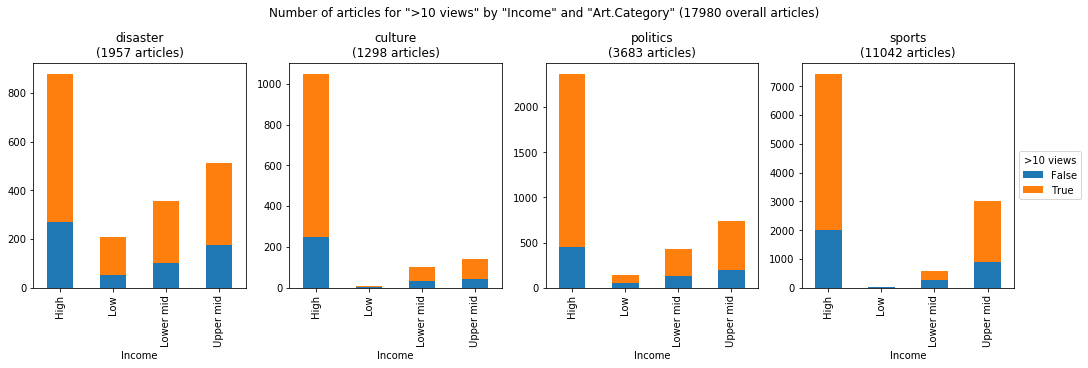

In [360]:
plot_cat_by_cat_variable(df_crawled, col_plot='cat', col_x = 'gni_class', col_bar='noticed', stacked=True, sharey=False, figsize=(15, 5))

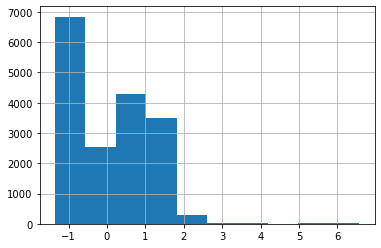

In [371]:
df_reg.GDP_pc_z.hist()

In [369]:
logit2_dict = fit_regression_and_rename_coeffs_by_cat(df_reg, 
                                                      f'noticed_int ~ {cat_reg} * GDP_pc_z + {region_reg} + view_country_article_log + views_baseline_log',
                                                      type='logit', show_summary=True, max_iter=100)

PseudoR² - Nagelkerke: 0.039 | Mcfadden: 0.026
PseudoR² - Nagelkerke: 0.191 | Mcfadden: 0.111
PseudoR² - Nagelkerke: 0.082 | Mcfadden: 0.046
PseudoR² - Nagelkerke: 0.106 | Mcfadden: 0.068
--------------- Summary for en ---------------
PseudoR² - Nagelkerke: 0.039 | Mcfadden: 0.026
                           Results: Generalized linear model
Model:                      GLM                      AIC:                    6742.0137  
Link Function:              logit                    BIC:                    -64424.9249
Dependent Variable:         noticed_int              Log-Likelihood:         -3355.0    
Date:                       2022-04-28 13:39         LL-Null:                -3444.8    
No. Observations:           7938                     Deviance:               6710.0     
Df Model:                   15                       Pearson chi2:           7.90e+03   
Df Residuals:               7922                     Scale:                  1.0000     
Method:                     IRLS  